This code reproduces Figure 2 in ITRPV-2020, which is the price trend for mono-Si modules between January, 2014 and January, 2020. This code generates a file based on the year specified (20 means 2020) and generates a file with the data for Table S1 for download that can be used with the pvmontecarlo file.  

Read in libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import os
from google.colab import files

import importlib.util

from matplotlib.colors import TwoSlopeNorm

repo_name = "PVRecycling"
repo_url = "https://github.com/pleu/PVRecycling.git"

if os.path.basename(os.getcwd()) == repo_name:
  os.chdir("/content")

if os.path.exists(repo_name):
  !rm -rf {repo_name}

!git clone {repo_url}
os.chdir(repo_name)

from unit_conversion import convert_dataframe_units
from unit_conversion import build_conversion_matrix

Cloning into 'PVRecycling'...
remote: Enumerating objects: 181, done.
remote: Counting objects: 100% (181/181), done.
remote: Compressing objects: 100% (134/134), done.
remote: Total 181 (delta 77), reused 145 (delta 42), pack-reused 0 (from 0)
Receiving objects: 100% (181/181), 1.55 MiB | 6.74 MiB/s, done.
Resolving deltas: 100% (77/77), done.


Read in the .csv file

In [4]:
data_file = "data/ITRPV_PV_prices.csv"
df = pd.read_csv(data_file, comment = '#')

df.tail(6)

,year,mono-module ($/Wp),mono-cell ($/Wp),mono-wafer ($/Wp),poly-Si ($/Wp)
1198,2020.0,0.250699,0.113098,0.072897,0.02683
1199,2021.0,0.244000,0.110000,0.071000,0.02611
1200,2022.0,0.240000,0.108270,0.069800,0.02568
1201,2023.0,0.228000,0.102860,0.066300,0.02440
1202,2024.0,0.118000,0.053230,0.034300,0.01263
1203,2025.0,0.080000,0.036100,0.023260,0.00856


Plot the data

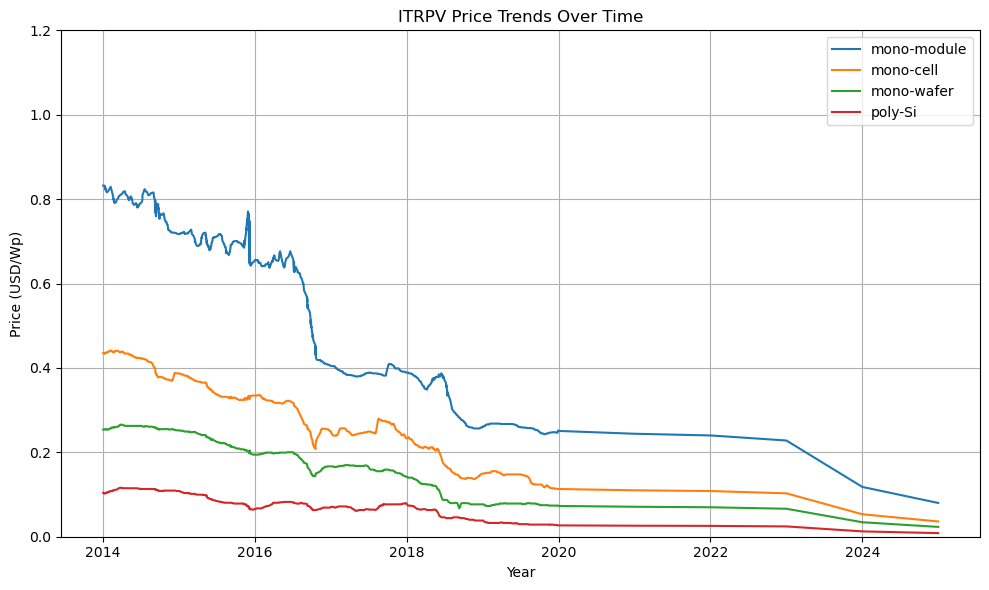

In [6]:
# Plotting
plt.figure(figsize=(10, 6))

# Plot each price curve
for col in ['mono-module ($/Wp)', 'mono-cell ($/Wp)', 'mono-wafer ($/Wp)', 'poly-Si ($/Wp)']:
  label = col.split(' ')[0]  # Removes everything after the first space
  plt.plot(df['year'], df[col], label=label)

# Styling the plot
plt.title("ITRPV Price Trends Over Time")
plt.xlabel("Year")
plt.ylabel("Price (USD/Wp)")
plt.ylim(0, 1.2)
plt.grid(True)
plt.legend()

# Force x-axis to show only integer ticks
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.tight_layout()
plt.show()

Convert Prices Into Process Cost in $/Wp And Match 2020 Paper

In [11]:
conversion_matrix = build_conversion_matrix(year)

cols = list(df.columns)[1:]  # Skip time column
diff_data = {'year': df['year']}

for i in range(len(cols) - 1):
 # new_col_name = f"{cols[i]} - {cols[i+1]}"
 diff_data[cols[i]] = df[cols[i]] - df[cols[i+1]]

# Add the last original column 'poly-Si ($/Wp)' to the new DataFrame
diff_data[cols[-1]] = df[cols[-1]]

df_diff = pd.DataFrame(diff_data)
df_diff

TypeError: 'builtin_function_or_method' object is not subscriptable

Convert Process Cost Into $/Unit And Match 2020 Paper. [Remanufacturing end-of-life silicon photovoltaics: Feasibility and viability analysis](https://onlinelibrary.wiley.com/doi/full/10.1002/pip.3376).  

In [ ]:
df_converted = df_diff.copy()
# Apply conversion factor: $/Wp to $/module
df_converted['mono-module ($/module)'] = df_diff['mono-module ($/Wp)'] * conversion_matrix.at['Wp', 'module']

# Apply conversion factor: $/Wp to $/cell
df_converted['mono-cell ($/cell)'] = df_diff['mono-cell ($/Wp)'] * conversion_matrix.at['Wp', 'cell']

# Apply conversion factor: $/Wp to $/wafer
df_converted['mono-wafer ($/wafer)'] = df_diff['mono-wafer ($/Wp)'] * conversion_matrix.at['Wp', 'wafer']

# Apply conversion factor: $/Wp to $/kg
df_converted['poly-Si ($/kg)'] = df_diff['poly-Si ($/Wp)'] * conversion_matrix.at['Wp', 'kg']

df_converted.tail()

,year,mono-module ($/Wp),mono-cell ($/Wp),mono-wafer ($/Wp),poly-Si ($/Wp),mono-module ($/module),mono-cell ($/cell),mono-wafer ($/wafer),poly-Si ($/kg)
1199,2021.0,0.13400,0.03900,0.04489,0.02611,113.870038,0.278967,0.321098,11.672802
1200,2022.0,0.13173,0.03847,0.04412,0.02568,111.941045,0.275176,0.315590,11.480565
1201,2023.0,0.12514,0.03656,0.04190,0.02440,106.341019,0.261514,0.299711,10.908325
1202,2024.0,0.06477,0.01893,0.02167,0.01263,55.040017,0.135406,0.155006,5.646399
1203,2025.0,0.04390,0.01284,0.01470,0.00856,37.305184,0.091845,0.105149,3.826855


The poly-Si process cost should minus cost of mg-Si to get the final number

In [ ]:
year = 2025  # 2025
mg_Si = 3.97

df_converted_input = df_converted.copy()
df_converted_input['mg-Si ($/kg)'] = mg_Si
df_converted_input['poly-Si ($/kg)'] = df_converted_input['poly-Si ($/kg)'] - mg_Si

df_with_index = df_converted_input.set_index('year')
df_with_index = df_with_index.reindex(df_with_index.index.union([year])).sort_index()
df_interpolated = df_with_index.interpolate(method='linear')

# Step 4: Extract the interpolated row
interpolated = df_interpolated.loc[year]
interpolated_dict = interpolated.to_dict()
var_name = f"manufacturing_values_{year}"
filename = 'manufacturing_values.py'
with open(filename, "w") as f:
 f.write(f"# Interpolated values for year = {year + 2000}\n")
 f.write(f"{var_name} = {{\n")
 for key, value in interpolated_dict.items():
  f.write(f"  {repr(key)}: {value:.6f},\n")
 f.write("}\n")

files.download(filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
interpolated

,2025.0
mono-module ($/Wp),0.043900
mono-cell ($/Wp),0.012840
mono-wafer ($/Wp),0.014700
poly-Si ($/Wp),0.008560
mono-module ($/module),37.305184
mono-cell ($/cell),0.091845
mono-wafer ($/wafer),0.105149
poly-Si ($/kg),-0.143145
mg-Si ($/kg),3.970000
